In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax

2024-05-17 17:41:16.780410: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 17:41:16.833731: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 17:41:17.668334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 415.2 kB/s eta 0:00:001m412.7 kB/s eta 0:00:01


In [2]:
Normal = ['/home/sandeep/shweta/stroke images/Training/Normal']
Stroke= ['/home/sandeep/shweta/stroke images/Training/Stroke']
file_p = []
labels = []
dict_lists = [Normal, Stroke]
class_labels = ['Normal', 'Stroke']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [3]:
df.head()

,filepaths,labels
0,/home/sandeep/shweta/stroke images/Training/No...,Normal
1,/home/sandeep/shweta/stroke images/Training/No...,Normal
2,/home/sandeep/shweta/stroke images/Training/No...,Normal
3,/home/sandeep/shweta/stroke images/Training/No...,Normal
4,/home/sandeep/shweta/stroke images/Training/No...,Normal


In [4]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(1593, 2)
(626, 2)
(282, 2)


In [ ]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [6]:
image_gen = ImageDataGenerator(
    rescale=1./255,#Normalisation process
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 1593 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 282 validated image filenames belonging to 2 classes.


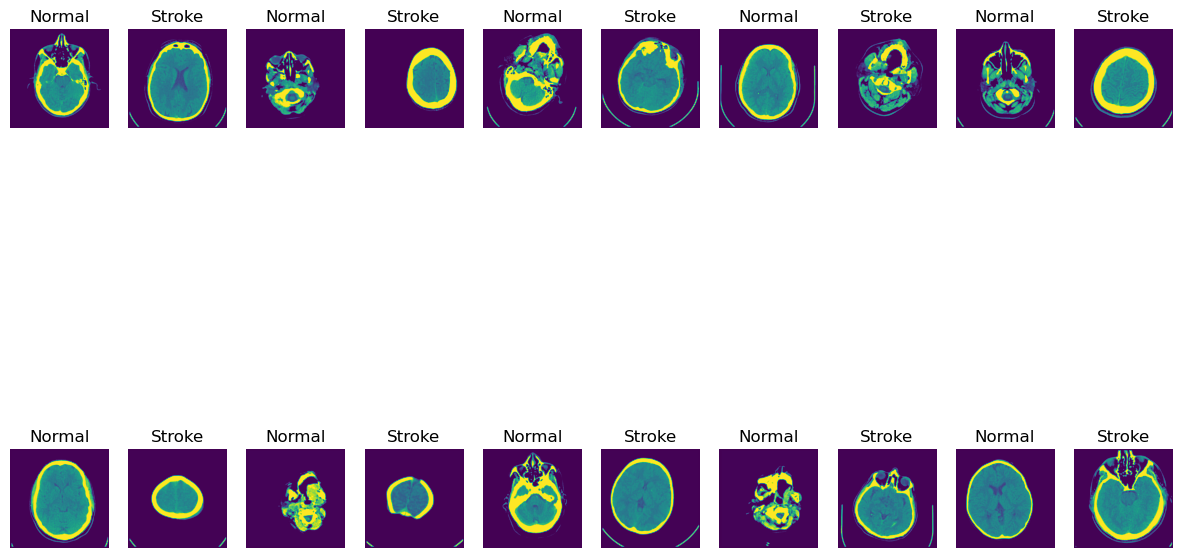

In [7]:
import matplotlib.pyplot as plt

# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()

In [8]:
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception

learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=500, validation_data=val)

2024-05-17 17:41:19.718423: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/500


/home/sandeep/miniconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 238s 9s/step - accuracy: 0.5947 - loss: 1.2501 - val_accuracy: 0.6206 - val_loss: 1.9397
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 215s 9s/step - accuracy: 0.8611 - loss: 0.3950 - val_accuracy: 0.6206 - val_loss: 2.1801
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 213s 8s/step - accuracy: 0.9604 - loss: 0.0968 - val_accuracy: 0.6348 - val_loss: 1.5949
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 217s 9s/step - accuracy: 0.9905 - loss: 0.0381 - val_accuracy: 0.6950 - val_loss: 1.1647
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 215s 9s/step - accuracy: 0.9980 - loss: 0.0134 - val_accuracy: 0.7660 - val_loss: 0.7562
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 220s 9s/step - accuracy: 0.9941 - loss: 0.0206 - val_accuracy: 0.7340 - val_loss: 1.0227
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 215s 9s/step - accuracy: 0.9959 - loss: 0.0159 - val_accuracy: 0.7908 - val_loss: 0.6479
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 214s 9s/step - accuracy: 0.9974 - loss: 0.0075 - val_accuracy: 0.9149 - val_l

In [12]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9887 - loss: 0.0723
Test Loss: 0.0905437096953392
Test Accuracy: 0.9872204661369324


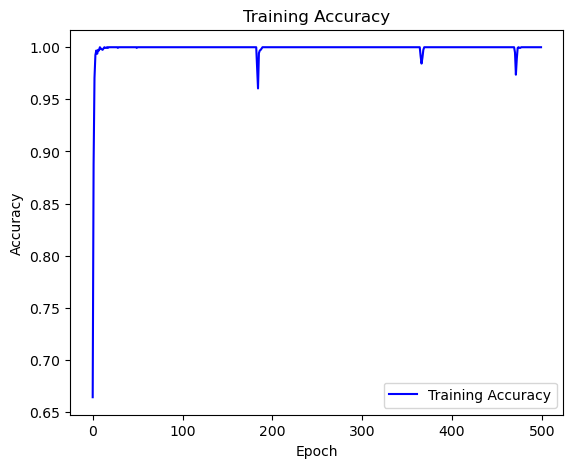

In [13]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


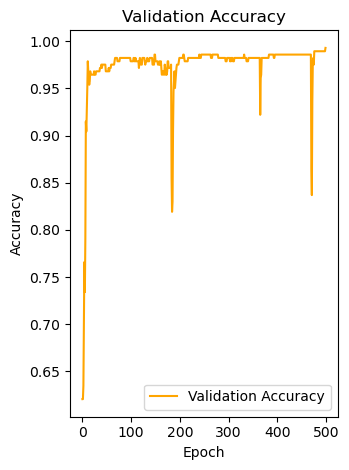

In [14]:
# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Plot training and validation loss
plt.figure(figsize=(14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

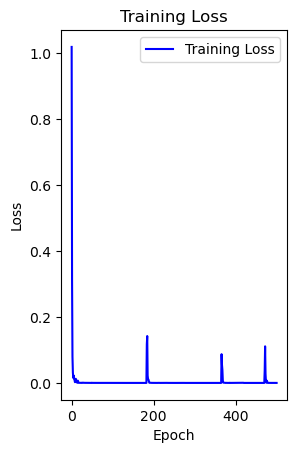

In [16]:
# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

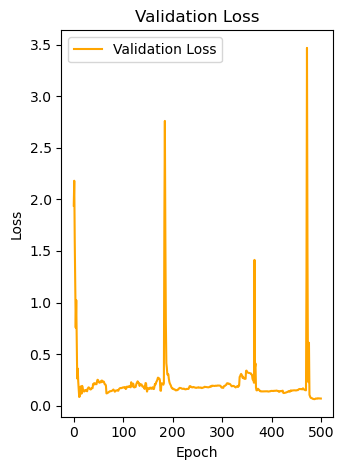

In [17]:
# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


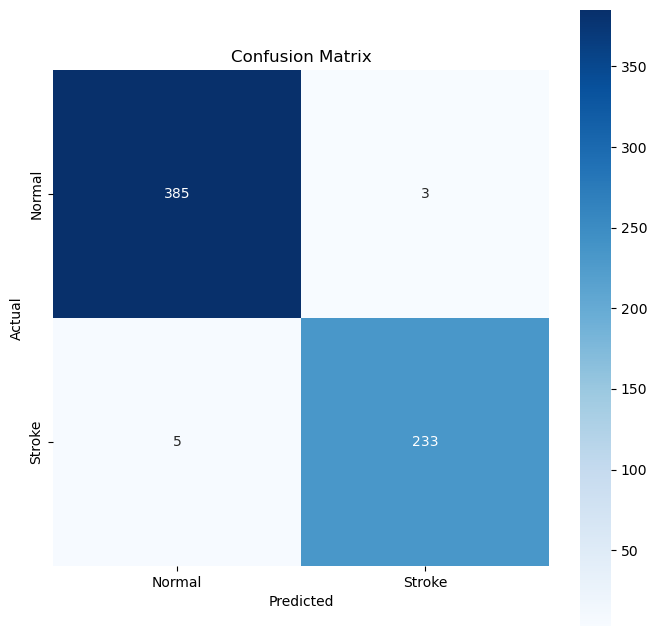

In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


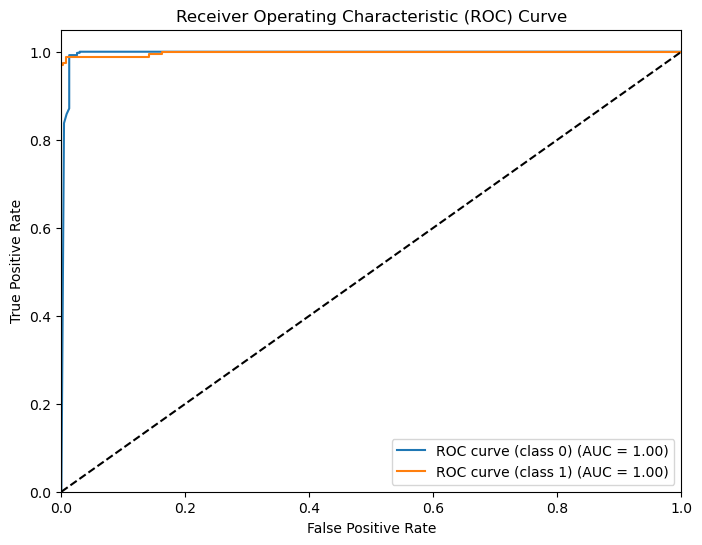

In [21]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(true_classes, y_pred[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(test.class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [22]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9887 - loss: 0.0723
Test Loss: 0.0905437096953392
Test Accuracy: 0.9872204661369324


In [23]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9916 - loss: 0.0848
Validation Loss: 0.0691642239689827
Validation Accuracy: 0.9929078221321106


In [24]:
# Extract training accuracy and loss from history object
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

# Print the final training accuracy and loss
final_train_accuracy = train_accuracy[-1]
final_train_loss = train_loss[-1]

print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)


Final Training Loss: 2.3599599444423802e-05
Final Training Accuracy: 1.0


In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Load VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers except the first three
for layer in base_model.layers[:3]:
    layer.trainable = True

# Add custom layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

# Create new model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=150, validation_data=val)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 260s 10s/step - accuracy: 0.5658 - loss: 1.8923 - val_accuracy: 0.6206 - val_loss: 0.6709
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 252s 10s/step - accuracy: 0.6260 - loss: 0.6660 - val_accuracy: 0.6206 - val_loss: 0.7019
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 254s 10s/step - accuracy: 0.6156 - loss: 0.6871 - val_accuracy: 0.6206 - val_loss: 0.6500
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 252s 10s/step - accuracy: 0.6329 - loss: 0.6399 - val_accuracy: 0.6170 - val_loss: 0.6417
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 251s 10s/step - accuracy: 0.6477 - loss: 0.6211 - val_accuracy: 0.6454 - val_loss: 0.6273
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 252s 10s/step - accuracy: 0.6829 - loss: 0.5843 - val_accuracy: 0.7021 - val_loss: 0.6061
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 251s 10s/step - accuracy: 0.6938 - loss: 0.5780 - val_accuracy: 0.6135 - val_loss: 0.6772
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 252s 10

In [2]:
# Assuming you have already defined and compiled the model with unfrozen layers

# Train the model with unfrozen layers
history_unfreeze = model_unfreeze.fit(train, epochs=150, validation_data=val)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Assuming you have already loaded the VGG16 model and set the first few layers to trainable

# Add custom dense layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # Assuming num_classes is the number of output classes

# Create model with base VGG16 layers frozen and custom dense layers trainable
model_unfreeze = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_unfreeze.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Assuming you have already loaded the VGG16 model and set the first few layers to trainable

# Add custom dense layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # Assuming num_classes is the number of output classes

# Create model with base VGG16 layers frozen and custom dense layers trainable
model_unfreeze = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_unfreeze.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


import matplotlib.pyplot as plt

# Plot training and validation accuracy for VGG16 model
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='VGG16 Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='VGG16 Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG16 Model')
plt.legend()
plt.show()

# Plot training and validation accuracy for unfrozen layers
plt.figure(figsize=(12, 6))
plt.plot(history_unfreeze.history['accuracy'], label='Unfrozen Layers Training Accuracy', color='blue')
plt.plot(history_unfreeze.history['val_accuracy'], label='Unfrozen Layers Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Unfrozen Layers')
plt.legend()
plt.show()


NameError: name 'model_unfreeze' is not defined

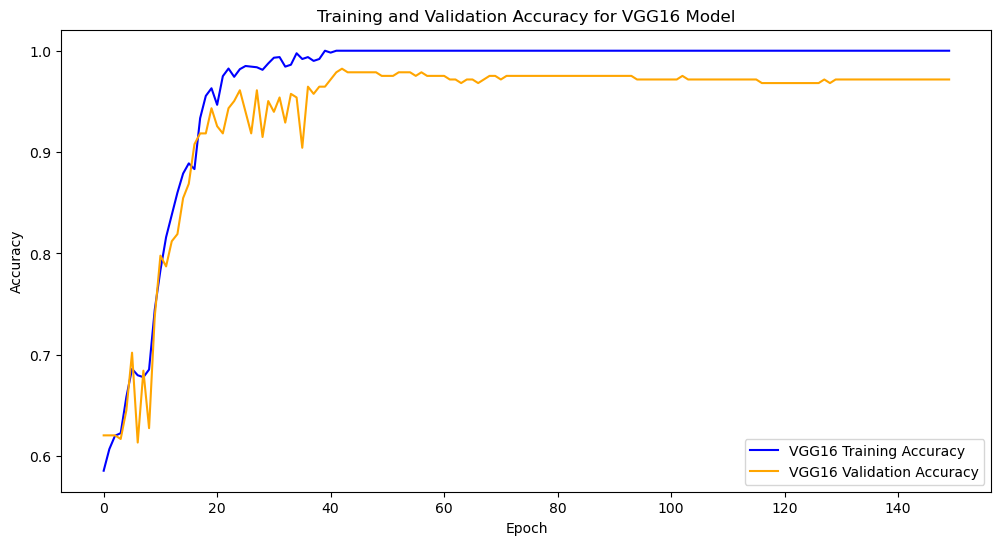

NameError: name 'history_unfreeze' is not defined

<Figure size 1200x600 with 0 Axes>

In [27]:
# Assuming you have already trained the model with unfrozen layers and stored its history object as 'history_unfreeze'

import matplotlib.pyplot as plt

# Plot training and validation accuracy for VGG16 model
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='VGG16 Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='VGG16 Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG16 Model')
plt.legend()
plt.show()

# Plot training and validation accuracy for unfrozen layers
plt.figure(figsize=(12, 6))
plt.plot(history_unfreeze.history['accuracy'], label='Unfrozen Layers Training Accuracy', color='blue')
plt.plot(history_unfreeze.history['val_accuracy'], label='Unfrozen Layers Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Unfrozen Layers')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Define the number of output classes
num_classes = 2  # Example: If you have 2 classes (e.g., Normal and Stroke)

# Load VGG19 model with pre-trained weights and without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom dense layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

# Create model with base VGG19 layers frozen and custom dense layers trainable
model_unfreeze = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_unfreeze.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_unfreeze.summary()


In [ ]:
# Assuming you have already loaded the train, val, and test data generators

# Train the model
history = model_unfreeze.fit(train, epochs=50, validation_data=val)

# Evaluate the model on test data
loss, accuracy = model_unfreeze.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
